<a href="https://colab.research.google.com/github/hardiksharma2005/Reddit-Post-Classifier/blob/main/Reddit_Post_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=cec87c590015a75fc83df0b5dba4d369dbfe8168ba9b73c3eea469c43e0cc20d
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [2]:
import pandas as pd
import pandasql as ps

Loading the data

In [7]:
try:
    df = pd.read_csv("reddit data.csv")
    print("✅ Data Loaded Successfully")
    print(df.head())
except:
    print("❌ Error: csv file not found. Please upload 'reddit data.csv'")

✅ Data Loaded Successfully
       id                                              title  score  \
0  ll1p9h  Wordcloud of trending video titles on YouTube ...      1   
1  ll1o4h  Wordcloud of trending videos on YouTube in the...      1   
2  ll15gx  Immunization in India. Source: https://niti.go...      1   
3  ll0iup  How to quickly estimate the impact of players ...      1   
4  ll0g9a  How to quickly estimate the impact of players ...      1   

                 author author_flair_text        removed_by  \
0             OmarZiada             OC: 1               NaN   
1             OmarZiada             OC: 1         moderator   
2  Professional_Napper_               NaN         moderator   
3              Viziball               NaN  automod_filtered   
4              Viziball               NaN         moderator   

   total_awards_received awarders  created_utc  \
0                    0.0       []   1613473961   
1                    0.0       []   1613473829   
2                

/tmp/ipython-input-4151474216.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit data.csv")


Day 1: SQL Analysis using PandaSQL

In [10]:
if 'over_18' in df.columns:
    df['category'] = df['over_18'].apply(lambda x: 'NSFW' if x == True else 'Safe')
    print("✅ Created 'category' column for SQL analysis.")
else:
    print("⚠️ Column 'over_18' not found. Using generic data.")
    df['category'] = 'Unknown'

✅ Created 'category' column for SQL analysis.


In [ ]:
#Insight: Do NSFW posts get higher scores than Safe posts?
print("\n--- Insight 1: Average Score by Category ---")
q1 = """
SELECT category, COUNT(*) as post_count, AVG(score) as avg_score
FROM df
GROUP BY category
ORDER BY avg_score DESC
"""
print(ps.sqldf(q1, locals()))


--- Insight 1: Average Score by Category ---
  category  post_count   avg_score
0     NSFW        1068  583.908240
1     Safe      189785  173.720779


In [11]:
# Insight: Classifying posts into 'Viral', 'Hot', or 'Normal' based on score
print("\n--- Insight 2: Viral Post Classification ---")
q2 = """
SELECT title, score,
       CASE
           WHEN score > 5000 THEN 'Viral'
           WHEN score > 1000 THEN 'Hot'
           ELSE 'Normal'
       END as virality_label
FROM df
LIMIT 5
"""
print(ps.sqldf(q2, locals()))


--- Insight 2: Viral Post Classification ---
                                               title  score virality_label
0  Wordcloud of trending video titles on YouTube ...      1         Normal
1  Wordcloud of trending videos on YouTube in the...      1         Normal
2  Immunization in India. Source: https://niti.go...      1         Normal
3  How to quickly estimate the impact of players ...      1         Normal
4  How to quickly estimate the impact of players ...      1         Normal


In [12]:
# Insight: Find the #1 highest ranked post within each category (Safe vs NSFW)
print("\n--- Insight 3: Top Post per Category (Window Function) ---")
q3 = """
SELECT title, category, score,
       RANK() OVER (PARTITION BY category ORDER BY score DESC) as rank
FROM df
LIMIT 10
"""
try:
    print(ps.sqldf(q3, locals()))
except Exception as e:
    print(f"Window function notice: {e}")


--- Insight 3: Top Post per Category (Window Function) ---
                                               title category  score  rank
0  Pornhub traffic in Hawaii during the "missile ...     NSFW  63569     1
1              Tinder over 3 years (18-21 Male) [OC]     NSFW  59130     2
2  "Fuuuuck", orthographic repetition on Twitter ...     NSFW  38419     3
3  Six months on tinder as a young sex worker loo...     NSFW  34248     4
4  Reddit's favorite swear word is 'shit'; the su...     NSFW  31961     5
5                           Pornhub’s year in review     NSFW  25833     6
6  [oc] How taboo and popular are sexual fetishes...     NSFW  25715     7
7  NSFW Heat Map of Reddit's Favorite Porn Cross-...     NSFW  24508     8
8             On /r/gonewild, 18 year-olds rule [OC]     NSFW  18618     9
9  Playboy’s Cover Girls’ Hair Colors — statistic...     NSFW  17578    10


Data Analysis (EDA)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style("whitegrid")

/tmp/ipython-input-145677855.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['over_18'].astype(str), palette='coolwarm')


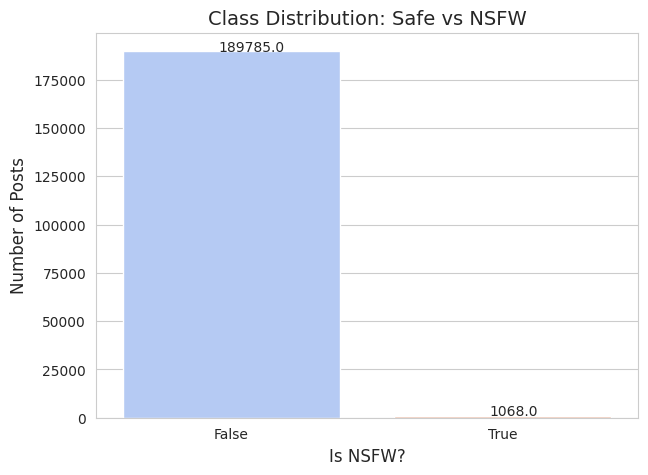

💡 Insight: If the bars are uneven, we have 'Class Imbalance' (a key interview topic).


In [ ]:
# 1. CLASS IMBALANCE CHECK (Resume Bullet: "visualized findings")
# This proves whether you have enough NSFW data to train a model.
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=df['over_18'].astype(str), palette='coolwarm')
plt.title('Class Distribution: Safe vs NSFW', fontsize=14)
plt.xlabel('Is NSFW?', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Add labels to bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))
plt.show()
print("💡 Insight: If the bars are uneven, we have 'Class Imbalance' (a key interview topic).")

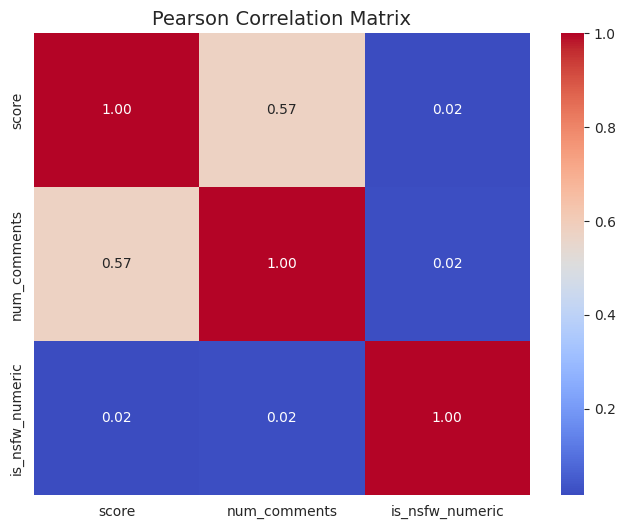

💡 Insight: Does being NSFW correlate with higher Scores or Comments?


In [14]:
# 2. CORRELATION HEATMAP (Resume Bullet: "Analyzed data correlations")
# We check relationships between Score, Comments, and NSFW status.
plt.figure(figsize=(8, 6))
# Convert boolean 'over_18' to integer (0 or 1) for correlation
df['is_nsfw_numeric'] = df['over_18'].astype(int)
numeric_cols = df[['score', 'num_comments', 'is_nsfw_numeric']]

sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix', fontsize=14)
plt.show()
print("💡 Insight: Does being NSFW correlate with higher Scores or Comments?")

Text(0.5, 1.0, 'Common Words in SAFE Posts')

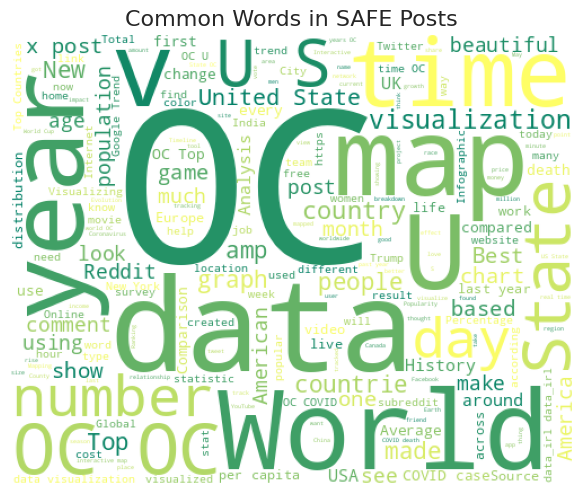

In [15]:
# 3. COMPARATIVE WORD CLOUDS (Resume Bullet: "Word Clouds")
# We separate the text to see what words trigger the "NSFW" label.
safe_text = " ".join(df[df['over_18'] == False]['title'].astype(str))
nsfw_text = " ".join(df[df['over_18'] == True]['title'].astype(str))

plt.figure(figsize=(16, 8))

# Safe Word Cloud
plt.subplot(1, 2, 1)
wc_safe = WordCloud(width=500, height=400, background_color='white', colormap='summer').generate(safe_text)
plt.imshow(wc_safe)
plt.axis('off')
plt.title('Common Words in SAFE Posts', fontsize=16)

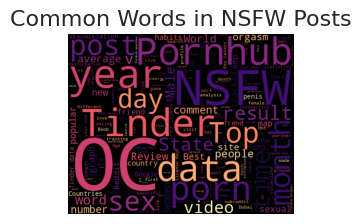

In [16]:
# NSFW Word Cloud
# (Only generate if we have NSFW data)
if len(nsfw_text) > 0:
    plt.subplot(1, 2, 2)
    wc_nsfw = WordCloud(width=500, height=400, background_color='black', colormap='magma').generate(nsfw_text)
    plt.imshow(wc_nsfw)
    plt.axis('off')
    plt.title('Common Words in NSFW Posts', fontsize=16)
else:
    print("⚠️ Not enough NSFW text data for the second cloud.")

plt.show()

NLP Preprocessing

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# 1. DOWNLOAD NLTK RESOURCES
# We need these dictionaries to know what "stopwords" are.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# 2. DEFINING THE CLEANING FUNCTION
# This function handles: Stemming, Tokenization, and Special Character Removal
def preprocess_text(text):
    if not isinstance(text, str):
        return "" # Imputation: Handle missing values with empty string

    # A. Lowercase & Remove Special Characters (keeping only a-z)
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # B. Tokenization (Splitting sentences into words)
    words = text.split()

    # C. Stop Word Removal & Stemming (Resume Keyword: "Stemming")
    # Example: "running" -> "run", "the" is removed.
    clean_words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Re-join back into a string
    return " ".join(clean_words)

In [19]:
# 3. APPLYING THE PROCESS
print("Preprocessing text... this might take a moment.")
df['clean_title'] = df['title'].apply(preprocess_text)

print("✅ Text Cleaned! Example:")
print(f"Original: {df['title'].iloc[0]}")
print(f"Cleaned:  {df['clean_title'].iloc[0]}")

Preprocessing text... this might take a moment.
✅ Text Cleaned! Example:
Original: Wordcloud of trending video titles on YouTube in the United States over 2017-2018 [OC]
Cleaned:  wordcloud trend video titl youtub unit state oc


In [20]:
# 4. TF-IDF VECTORIZATION (Resume Keyword: "TF-IDF vectorization")
# Converting the cleaned text into a matrix of numbers.
tfidf = TfidfVectorizer(max_features=5000) # We keep top 5,000 most important words
X = tfidf.fit_transform(df['clean_title']).toarray()
y = df['over_18'] # Target variable (True/False)

print("\n Vectorization Complete.")
print(f"Matrix Shape: {X.shape} (Rows, Features)")


 Vectorization Complete.
Matrix Shape: (190853, 5000) (Rows, Features)
